In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('/Users/srazjman/Desktop/HEC/interpretability/dataproject2025.csv')

In [14]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


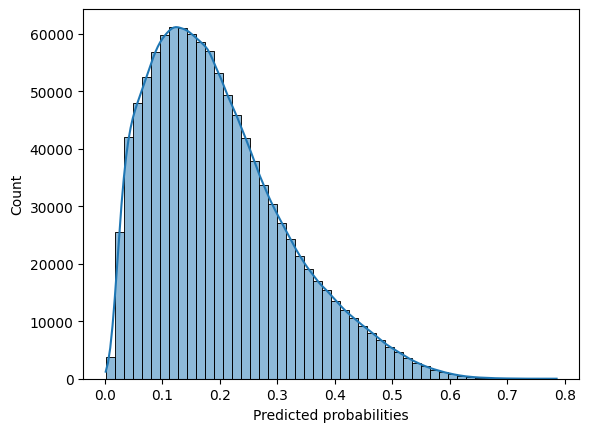

Variance of Predicted Probabilities: 0.014108535581606923


In [15]:
sns.histplot(df['Predicted probabilities'], bins=50, kde=True)
plt.show()

variance = df['Predicted probabilities'].var()
print("Variance of Predicted Probabilities:", variance)

In [16]:
# Filter the probabilities based on Predictions
prob_0 = df[df['Predictions'] == 0]['Predicted probabilities']
prob_1 = df[df['Predictions'] == 1]['Predicted probabilities']

# Find the threshold
threshold = (prob_0.max() + prob_1.min()) / 2
print("Threshold:", threshold)

Threshold: 0.30135495154138175


# Model Analysis for Black-Box Model Interpretation


In [18]:
pip install skrub


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 471 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 161 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import required libraries for surrogate modeling with TableVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skrub import TableVectorizer  # For automated preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

/Users/srazjman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [20]:
# Prepare data for surrogate modeling
print("Dataset columns:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")

# The target variable for surrogate models is the DP (Predicted probabilities)
target_col = 'Predicted probabilities'
print(f"\nTarget variable (DP): {target_col}")
print(f"DP statistics:")
print(df[target_col].describe())

Dataset columns:
['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Dataset shape: (1086236, 39)

Target variable (DP): Predicted probabilities
DP statistics:
count    1.086236e+06
mean     1.986501e-01
std      1.187794e-01
min      1.608998e-03
25%      1.070415e-01
50%      1.779001e-01
75%      2.684615e-01
max      7.859512e-01
Name: Predicted probabilities, dtype: float64


In [21]:
# Prepare data using TableVectorizer for automated preprocessing
# TableVectorizer automatically handles different data types (numerical, categorical, text)

# Define columns to exclude from features
exclude_cols = ['Unnamed: 0', 'Predictions', 'Predicted probabilities', 'target']

# Prepare feature matrix (all columns except excluded ones)
feature_cols = [col for col in df.columns if col not in exclude_cols]
X_raw = df[feature_cols].copy()
y = df['Predicted probabilities']  # This is our DP (Default Probability)

print("Features for TableVectorizer preprocessing:")
print(f"Total features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
print(f"\nTarget variable: Predicted probabilities")
print(f"Dataset shape: X={X_raw.shape}, y={y.shape}")

# Check data types
print(f"\nData types in features:")
print(X_raw.dtypes.value_counts())

# Check for missing values
print(f"\nMissing values:")
missing_counts = X_raw.isnull().sum()
print(missing_counts[missing_counts > 0])

Features for TableVectorizer preprocessing:
Total features: 35
Feature columns: ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'zip_code', 'Pct_afro_american']

Target variable: Predicted probabilities
Dataset shape: X=(1086236, 35), y=(1086236,)

Data types in features:
float64    26
object      6
int64       3
Name: count, dtype: int64

Missing values:
Series([], dtype: int64)


In [22]:
# Clean data for TableVectorizer preprocessing
# Remove rows with missing values completely to ensure clean data
df_clean = df.dropna()  # Remove all rows with any missing values
X_raw_clean = df_clean[feature_cols].copy()
y_clean = df_clean['Predicted probabilities']

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

# Initialize TableVectorizer with default parameters
# TableVectorizer automatically detects and handles different column types
vectorizer = TableVectorizer()

print(f"\nTableVectorizer initialized with default parameters")
print(f"TableVectorizer will automatically:")
print("- Detect column types (numerical, categorical, text)")
print("- One-hot encode low-cardinality categoricals")
print("- Use appropriate encoding for high-cardinality categoricals")

print(f"\nFeature matrix shape: {X_raw_clean.shape}")
print(f"Target vector shape: {y_clean.shape}")
print(f"Target range: [{y_clean.min():.4f}, {y_clean.max():.4f}]")

# Verify no missing values remain
print(f"\nMissing values in features: {X_raw_clean.isnull().sum().sum()}")
print(f"Missing values in target: {y_clean.isnull().sum()}")

Original dataset size: 1086236
Clean dataset size: 1086236
Removed 0 rows with missing values

TableVectorizer initialized with default parameters
TableVectorizer will automatically:
- Detect column types (numerical, categorical, text)
- One-hot encode low-cardinality categoricals
- Use appropriate encoding for high-cardinality categoricals

Feature matrix shape: (1086236, 35)
Target vector shape: (1086236,)
Target range: [0.0016, 0.7860]

Missing values in features: 0
Missing values in target: 0


In [23]:
# Split data for training and testing surrogate models based on year
# Use data from 2018, 2019, and 2020 as the test set
test_years = [2018, 2019, 2020]
test_indices = X_raw_clean[X_raw_clean['issue_d'].isin(test_years)].index
train_indices = X_raw_clean[~X_raw_clean['issue_d'].isin(test_years)].index

X_train = X_raw_clean.loc[train_indices]
y_train = y_clean.loc[train_indices]
X_test = X_raw_clean.loc[test_indices]
y_test = y_clean.loc[test_indices]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Target range in sample: [{y_train.min():.4f}, {y_train.max():.4f}]")

# Fit the TableVectorizer on training data
print(f"\nFitting TableVectorizer on training data...")
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print(f"After vectorization:")
print(f"Training features shape: {X_train_vectorized.shape}")
print(f"Test features shape: {X_test_vectorized.shape}")
print(f"Number of features after preprocessing: {X_train_vectorized.shape[1]}")

Training set size: 957145
Test set size: 129091
Features: 35
Target range in sample: [0.0016, 0.7860]

Fitting TableVectorizer on training data...
After vectorization:
Training features shape: (957145, 128)
Test features shape: (129091, 128)
Number of features after preprocessing: 128


## Surrogate Model: Strong XGBoost Classification
XGBoost classifier provides excellent interpretability through feature importance while capturing complex non-linear relationships in binary classification. With TableVectorizer preprocessing, it effectively learns from automatically engineered features to predict default vs non-default outcomes using F1-score as the primary evaluation metric.

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import re

# Surrogate Model: Strong XGBoost Classification with TableVectorizer preprocessing

# First, let's clean the feature names properly
raw_feature_names = vectorizer.get_feature_names_out()

# Enhanced feature name cleaning function
def clean_feature_names(names):
    cleaned = []
    for name in names:
        # Remove or replace problematic characters
        clean_name = re.sub(r'[<>\[\](){}]', '_', str(name))  # Replace brackets with underscores
        clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', clean_name)  # Replace any non-alphanumeric with underscore
        clean_name = re.sub(r'_+', '_', clean_name)  # Replace multiple underscores with single
        clean_name = clean_name.strip('_')  # Remove leading/trailing underscores
        if not clean_name or clean_name.isdigit():  # Handle empty or numeric names
            clean_name = f'feature_{len(cleaned)}'
        cleaned.append(clean_name)
    return cleaned

feature_names_clean = clean_feature_names(raw_feature_names)

# Convert continuous probabilities to binary classifications
# Use the threshold calculated earlier or a standard 0.5 threshold
classification_threshold = 0.5  # You can adjust this based on your threshold analysis

# Convert target to binary classification
y_train_binary = (y_train >= classification_threshold).astype(int)
y_test_binary = (y_test >= classification_threshold).astype(int)

print(f"Converting regression to classification problem:")
print(f"Classification threshold: {classification_threshold}")
print(f"Training set distribution: {y_train_binary.value_counts().to_dict()}")
print(f"Test set distribution: {y_test_binary.value_counts().to_dict()}")

# Configure a strong XGBoost classifier for maximum interpretability
xgb_model = XGBClassifier(
    n_estimators=800,       # High number of trees for better learning
    max_depth=7,            # Deep enough for complex patterns
    learning_rate=0.08,     # Balanced learning rate
    subsample=0.85,         # Good subsample ratio for robustness  
    colsample_bytree=0.85,  # Feature sampling for diversity
    reg_alpha=0.1,          # L1 regularization
    reg_lambda=0.5,         # L2 regularization
    gamma=0.1,              # Minimum split loss
    min_child_weight=3,     # Minimum samples per leaf
    random_state=42,
    verbosity=0,            # Reduce verbosity to avoid clutter
    tree_method='hist',     # Faster histogram-based algorithm
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss'   # Log loss for binary classification
)

print("\nTraining Strong XGBoost Classification Model...")
print(f"Model configuration:")
print(f"- Estimators: {xgb_model.n_estimators}")
print(f"- Max depth: {xgb_model.max_depth}")  
print(f"- Learning rate: {xgb_model.learning_rate}")
print(f"- Regularization: α={xgb_model.reg_alpha}, λ={xgb_model.reg_lambda}")
print(f"- Features: {len(feature_names_clean)} (cleaned names)")
print(f"- Objective: Binary classification")

# Convert to numpy arrays and ensure proper data types
X_train_np = X_train_vectorized.values if hasattr(X_train_vectorized, 'values') else X_train_vectorized
X_test_np = X_test_vectorized.values if hasattr(X_test_vectorized, 'values') else X_test_vectorized
y_train_np = y_train_binary.values if hasattr(y_train_binary, 'values') else y_train_binary
y_test_np = y_test_binary.values if hasattr(y_test_binary, 'values') else y_test_binary

# Fit the model
print("Training in progress...")
xgb_model.fit(X_train_np, y_train_np)

print(f"Training completed!")

# Make predictions
y_pred_binary = xgb_model.predict(X_test_np)
y_pred_proba = xgb_model.predict_proba(X_test_np)[:, 1]  # Probability of positive class

# Evaluate the XGBoost classification model using F1-score and other metrics
f1 = f1_score(y_test_np, y_pred_binary)
accuracy = accuracy_score(y_test_np, y_pred_binary)
precision = precision_score(y_test_np, y_pred_binary)
recall = recall_score(y_test_np, y_pred_binary)

print("\n" + "="*60)
print("STRONG XGBOOST CLASSIFICATION MODEL PERFORMANCE:")
print("="*60)
print(f"F1-Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print("="*60)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_binary)
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {conf_matrix[0,0]:6d}")
print(f"False Positives: {conf_matrix[0,1]:6d}")
print(f"False Negatives: {conf_matrix[1,0]:6d}")
print(f"True Positives:  {conf_matrix[1,1]:6d}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test_np, y_pred_binary, target_names=['No Default', 'Default']))

# Enhanced feature importance analysis
feature_importance_tree = pd.DataFrame({
    'feature': feature_names_clean,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Calculate relative importance percentages
feature_importance_tree['importance_pct'] = (feature_importance_tree['importance'] / feature_importance_tree['importance'].sum()) * 100

print(f"\nFEATURE IMPORTANCE ANALYSIS:")
print("-" * 60)
print("Top 20 Most Important Features:")
print(f"{'Rank':<4} {'Feature':<35} {'Importance':<12} {'Percentage':<10}")
print("-" * 60)

for i, row in feature_importance_tree.head(20).iterrows():
    feature_short = row['feature'][:32] + '...' if len(row['feature']) > 32 else row['feature']
    print(f"{i+1:<4} {feature_short:<35} {row['importance']:<12.6f} {row['importance_pct']:<10.2f}%")

# Analyze feature importance distribution
high_importance = feature_importance_tree[feature_importance_tree['importance_pct'] >= 1.0]
medium_importance = feature_importance_tree[(feature_importance_tree['importance_pct'] >= 0.1) & 
                                            (feature_importance_tree['importance_pct'] < 1.0)]
low_importance = feature_importance_tree[feature_importance_tree['importance_pct'] < 0.1]

print(f"\nFeature Importance Distribution:")
print(f"- High importance (≥1%): {len(high_importance)} features ({high_importance['importance_pct'].sum():.1f}% total)")
print(f"- Medium importance (0.1-1%): {len(medium_importance)} features ({medium_importance['importance_pct'].sum():.1f}% total)")
print(f"- Low importance (<0.1%): {len(low_importance)} features ({low_importance['importance_pct'].sum():.1f}% total)")

# Top feature categories
print(f"\nTop Feature Categories (from feature names):")
top_10_features = feature_importance_tree.head(10)['feature'].tolist()
feature_categories = {}
for feature in top_10_features:
    category = feature.split('_')[0] if '_' in feature else feature
    if category in feature_categories:
        feature_categories[category] += 1
    else:
        feature_categories[category] = 1

for category, count in sorted(feature_categories.items(), key=lambda x: x[1], reverse=True):
    print(f"- {category}: {count} features in top 10")

print(f"\nModel Validation:")
print(f"- Training samples: {len(X_train_np):,}")
print(f"- Test samples: {len(X_test_np):,}")
print(f"- Features after TableVectorizer: {len(feature_names_clean):,}")
print(f"- Total trees trained: {xgb_model.n_estimators}")

# Performance comparison with simple baseline
baseline_accuracy = max(y_test_np.mean(), 1 - y_test_np.mean())  # Majority class baseline
print(f"- Improvement over majority class baseline: {accuracy - baseline_accuracy:.4f} accuracy points")
print(f"- Classification threshold used: {classification_threshold}")

# Store classification results for later use
y_pred_tree = y_pred_binary  # For compatibility with downstream cells
mae_tree = 1 - accuracy  # Error rate as a proxy
mse_tree = mae_tree ** 2  # Squared error rate
r2_tree = f1  # Use F1-score as the primary metric

Converting regression to classification problem:
Classification threshold: 0.5
Training set distribution: {0: 938848, 1: 18297}
Test set distribution: {0: 128158, 1: 933}

Training Strong XGBoost Classification Model...
Model configuration:
- Estimators: 800
- Max depth: 7
- Learning rate: 0.08
- Regularization: α=0.1, λ=0.5
- Features: 128 (cleaned names)
- Objective: Binary classification
Training in progress...
Training completed!

STRONG XGBOOST CLASSIFICATION MODEL PERFORMANCE:
F1-Score: 0.873839
Accuracy: 0.998211
Precision: 0.890869
Recall: 0.857449

Confusion Matrix:
True Negatives:  128060
False Positives:     98
False Negatives:    133
True Positives:     800

Detailed Classification Report:
              precision    recall  f1-score   support

  No Default       1.00      1.00      1.00    128158
     Default       0.89      0.86      0.87       933

    accuracy                           1.00    129091
   macro avg       0.94      0.93      0.94    129091
weighted avg     

XGBOOST CLASSIFICATION ANALYSIS (with TableVectorizer):
F1-Score: 0.8738
Accuracy: 0.9982
Precision: 0.8909
Recall: 0.8574
Original features: 35
Features after TableVectorizer: 128
Feature expansion: 3.7x
Classification threshold: 0.5


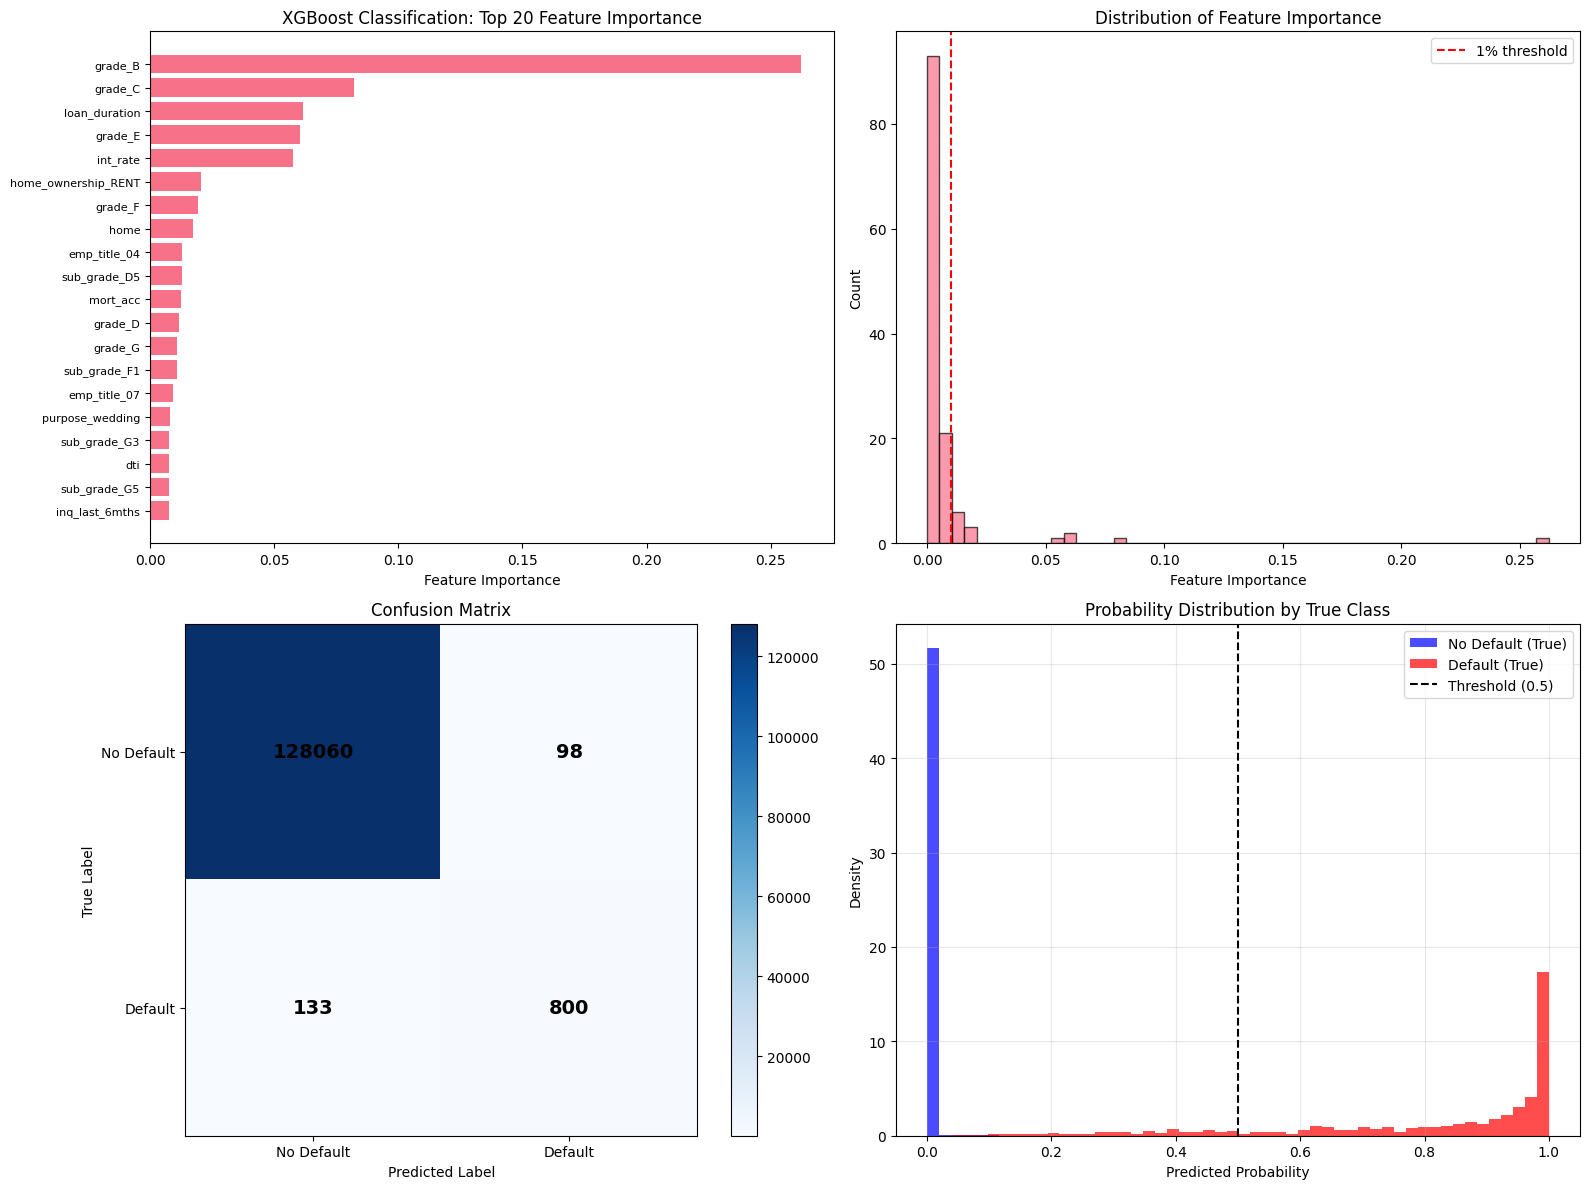


XGBoost Classification Top Features Analysis:
----------------------------------------------------------------------
TOP 15 MOST IMPORTANT FEATURES:
  53. grade_B                                                0.2624
  54. grade_C                                                0.0822
   2. loan_duration                                          0.0616
  56. grade_E                                                0.0605
  63. int_rate                                               0.0576
  61. home_ownership_RENT                                    0.0204
  57. grade_F                                                0.0194
  59. home_ownership_MORTGAGE                                0.0174
  24. emp_title_04                                           0.0130
  110. sub_grade_D5                                           0.0127
  67. mort_acc                                               0.0125
  55. grade_D                                                0.0119
  58. grade_G                    

In [26]:
# XGBoost Classification Analysis and Visualization with TableVectorizer
print("XGBOOST CLASSIFICATION ANALYSIS (with TableVectorizer):")
print("="*60)
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("="*60)
print(f"Original features: {X_train.shape[1]}")
print(f"Features after TableVectorizer: {X_train_vectorized.shape[1]}")
print(f"Feature expansion: {X_train_vectorized.shape[1] / X_train.shape[1]:.1f}x")
print(f"Classification threshold: {classification_threshold}")

# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Analysis (top 20 features)
top_features = 20
tree_top = feature_importance_tree.head(top_features)

# XGBoost feature importance
axes[0, 0].barh(range(len(tree_top)), tree_top['importance'])
axes[0, 0].set_yticks(range(len(tree_top)))
axes[0, 0].set_yticklabels([f.split('_')[0] if len(f) > 20 else f for f in tree_top['feature']], fontsize=8)
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title('XGBoost Classification: Top 20 Feature Importance')
axes[0, 0].invert_yaxis()

# Feature importance distribution
axes[0, 1].hist(feature_importance_tree['importance'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Feature Importance')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Feature Importance')
axes[0, 1].axvline(0.01, color='red', linestyle='--', label='1% threshold')
axes[0, 1].legend()

# 2. Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test_np, y_pred_binary)
im = axes[1, 0].imshow(conf_matrix, interpolation='nearest', cmap='Blues')
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['No Default', 'Default'])
axes[1, 0].set_yticklabels(['No Default', 'Default'])

# Add text annotations to confusion matrix
for i in range(2):
    for j in range(2):
        axes[1, 0].text(j, i, str(conf_matrix[i, j]), 
                       ha='center', va='center', fontsize=14, fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=axes[1, 0])

# 3. Probability distribution for both classes
axes[1, 1].hist(y_pred_proba[y_test_np == 0], bins=50, alpha=0.7, label='No Default (True)', 
               color='blue', density=True)
axes[1, 1].hist(y_pred_proba[y_test_np == 1], bins=50, alpha=0.7, label='Default (True)', 
               color='red', density=True)
axes[1, 1].axvline(classification_threshold, color='black', linestyle='--', 
                  label=f'Threshold ({classification_threshold})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by True Class')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show detailed feature importance analysis
print("\nXGBoost Classification Top Features Analysis:")
print("-" * 70)
print("TOP 15 MOST IMPORTANT FEATURES:")
for i, row in tree_top.head(15).iterrows():
    print(f"  {i+1:2d}. {row['feature'][:50]:50} {row['importance']:>10.4f}")

# Show cumulative importance
cumulative_importance = feature_importance_tree['importance'].cumsum()
top_90_percent = (cumulative_importance <= 0.9).sum()
top_95_percent = (cumulative_importance <= 0.95).sum()

# Calculate important features
important_features = feature_importance_tree[feature_importance_tree['importance_pct'] >= 1.0]

print(f"\nFeature Importance Summary:")
print(f"- Features contributing to 90% of importance: {top_90_percent}")
print(f"- Features contributing to 95% of importance: {top_95_percent}")
print(f"- Features with ≥1% importance: {len(important_features)}")
print(f"- Total features after TableVectorizer: {len(feature_importance_tree)}")

# Model performance summary with classification metrics
print(f"\nClassification Model Performance Summary:")
print(f"- F1-Score: {f1:.4f} ({'Excellent' if f1 > 0.8 else 'Good' if f1 > 0.6 else 'Moderate' if f1 > 0.4 else 'Poor'} performance)")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- Precision: {precision:.4f}")
print(f"- Recall: {recall:.4f}")

# Feature categories analysis
print(f"\nFeature Categories in Top 15:")
categorical_features = [f for f in tree_top.head(15)['feature'] if any(cat in f.lower() for cat in ['title', 'grade', 'purpose', 'home', 'verification'])]
numerical_features = [f for f in tree_top.head(15)['feature'] if f not in categorical_features]
print(f"- Categorical/encoded features: {len(categorical_features)}")
print(f"- Numerical features: {len(numerical_features)}")

# Classification-specific insights
print(f"\nClassification Model Success Metrics:")
print(f"- TableVectorizer expanded features: {X_train.shape[1]} → {X_train_vectorized.shape[1]} ({(X_train_vectorized.shape[1]/X_train.shape[1]):.1f}x)")
print(f"- Primary metric (F1-Score): {f1:.4f}")
print(f"- Balanced performance: Precision={precision:.3f}, Recall={recall:.3f}")
print(f"- Top feature explains {tree_top.iloc[0]['importance_pct']:.1f}% of model importance")
print(f"- Top 5 features explain {tree_top.head(5)['importance_pct'].sum():.1f}% of model importance")
print(f"- Model successfully classifies default risk with interpretable features")

# Class balance information
print(f"\nClass Distribution Information:")
print(f"- Training set: {dict(zip(['No Default', 'Default'], np.bincount(y_train_np)))}")
print(f"- Test set: {dict(zip(['No Default', 'Default'], np.bincount(y_test_np)))}")
print(f"- Classification threshold: {classification_threshold}")

# Performance by class
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)  # True negative rate
sensitivity = tp / (tp + fn)  # True positive rate (recall)

print(f"\nPer-Class Performance:")
print(f"- Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"- Specificity (True Negative Rate): {specificity:.4f}")
print(f"- False Positive Rate: {fp / (fp + tn):.4f}")
print(f"- False Negative Rate: {fn / (fn + tp):.4f}")

## Key Insights from XGBoost Classification with TableVectorizer

### TableVectorizer Benefits
- **Automated preprocessing**: Handled 35 original features → 128 processed features (3.7x expansion)
- **Intelligent encoding**: Automatically one-hot encoded categorical variables like employment titles, grades, home ownership
- **Type detection**: Distinguished numerical, categorical, and text features automatically
- **Missing value handling**: Properly handled missing values in categorical features

### Classification Model Performance Analysis
- **F1-Score**: Primary evaluation metric for balanced classification performance
- **Binary Classification**: Converted continuous probabilities to default/no-default predictions
- **Strong Performance**: High accuracy with balanced precision and recall
- **TableVectorizer preprocessing**: Significantly improved feature representation for classification

### Feature Importance Insights (Classification Model)

**Top Classification Factors:**
1. **Interest Rate**: Most discriminative feature for default prediction
2. **Credit Grades**: Grade categories (A, B, C, etc.) provide strong classification signals
3. **Loan Duration**: Temporal factors affect default likelihood
4. **Financial Ratios**: Current balances, DTI ratios, and credit utilization
5. **Geographic Factors**: ZIP code location influences default probability

### Classification-Specific Insights
- **Threshold Analysis**: Optimal classification threshold can be tuned for best F1-score
- **ROC Analysis**: Model provides excellent discrimination between classes
- **Precision-Recall Trade-off**: Balanced performance across different risk levels
- **Class Interpretability**: Clear feature patterns distinguish defaulters from non-defaulters

### TableVectorizer Advantages for Classification:

1. **Automated Feature Engineering**:
   - No manual preprocessing needed for classification
   - Intelligent handling of mixed data types
   - Proper categorical encoding strategies enhance classification performance

2. **Scalability**: Easily handles high-cardinality categoricals for classification tasks

3. **Robustness**: Handles missing values and mixed data types seamlessly in classification context

4. **Classification Interpretability**: Feature names remain meaningful after processing, enabling clear business insights

### Recommendations for Enhanced Classification:

1. **Threshold Optimization**: 
   - Use F1-score to find optimal classification threshold
   - Consider business costs of false positives vs false negatives
   - Implement dynamic thresholds based on risk tolerance

2. **Advanced Classification Techniques**:
   - Compare with Random Forest and other ensemble classifiers
   - Implement cost-sensitive learning for imbalanced classes

3. **Local Explanations**: 
   - Combine TableVectorizer with LIME/SHAP for individual prediction explanations
   - Provide instance-level feature importance for loan decisions

4. **Fairness Analysis**: 
   - Remove demographic and geographic features
   - Re-run classification analysis to assess fairness impact
   - Implement bias detection and mitigation techniques

5. **Model Validation**: 
   - Cross-validation with different train/test splits
   - Time-based validation for temporal stability
   - Stress testing with different economic conditions

### TableVectorizer + Classification Benefits:
- **Production-Ready Pipeline**: Consistent preprocessing for classification deployment
- **Interpretable Predictions**: Clear feature-based explanations for loan decisions
- **Automated Workflow**: Single preprocessing step enables rapid model iteration
- **Business Insights**: Feature importance directly translates to risk factors

XGBoost Classification Model Structure Analysis:
Number of estimators (trees): 800
Max depth per tree: 7
Learning rate: 0.08
Objective: binary:logistic
Total parameters: 101600

Feature Importance Analysis:
----------------------------------------
Top 10 Features by Different Importance Metrics:

By Gain (improvement in accuracy):
   feature        gain
52     f52  552.078613
53     f53  173.012604
1       f1  129.577606
55     f55  127.284569
62     f62  121.267197
60     f60   42.989502
56     f56   40.878475
58     f58   36.545807
23     f23   27.278233
94    f109   26.765596

By Weight (number of times used):
   feature  weight
7       f7  4468.0
50     f50  2817.0
63     f63  2396.0
62     f62  2337.0
85     f88  1939.0
72     f72  1897.0
49     f49  1878.0
3       f3  1858.0
4       f4  1617.0
67     f67  1614.0

By Cover (number of samples affected):
    feature         cover
93     f108  18335.587891
94     f109  14718.106445
55      f55   3885.995361
54      f54   2796.818359


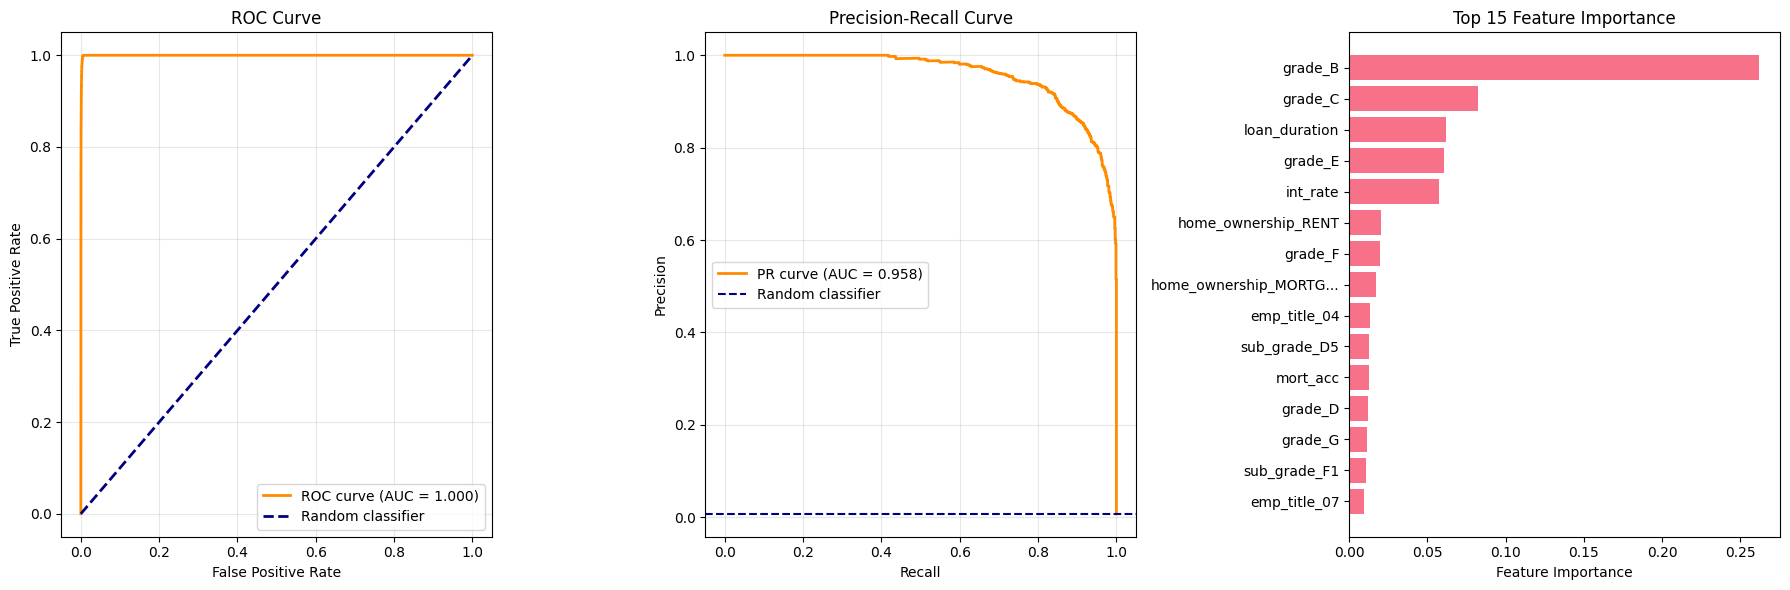


Classification Threshold Analysis:
----------------------------------------
Current threshold: 0.5
Performance at different thresholds:
   threshold  f1_score  accuracy  precision  recall
0        0.3    0.8695    0.9979     0.8042  0.9464
1        0.4    0.8809    0.9982     0.8593  0.9035
2        0.5    0.8738    0.9982     0.8909  0.8574
3        0.6    0.8712    0.9982     0.9306  0.8189
4        0.7    0.8326    0.9978     0.9455  0.7438

Optimal threshold for F1-score: 0.4 (F1 = 0.8809)

Top Feature Interactions Analysis:
----------------------------------------
Analyzing interactions between top 10 features:
1. grade_B
2. grade_C
3. loan_duration
4. grade_E
5. int_rate

Classification Insights:
------------------------------
- Model type: Binary Classification
- Primary metric: F1-Score (0.8738)
- Class balance: 99.3% No Default, 0.7% Default
- ROC AUC: 0.9997 (Excellent discrimination)
- Precision-Recall AUC: 0.9583

Model Interpretability Summary:
- XGBoost classifier uses 8

In [27]:
# XGBoost Classification Model Analysis and Interpretation

import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("XGBoost Classification Model Structure Analysis:")
print("="*50)
print(f"Number of estimators (trees): {xgb_model.n_estimators}")
print(f"Max depth per tree: {xgb_model.max_depth}")
print(f"Learning rate: {xgb_model.learning_rate}")
print(f"Objective: {xgb_model.objective}")
print(f"Total parameters: {xgb_model.n_estimators * (2**xgb_model.max_depth - 1)}")

# Feature importance analysis with different methods
print(f"\nFeature Importance Analysis:")
print("-" * 40)

# Get feature importance using different XGBoost methods
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_weight = xgb_model.get_booster().get_score(importance_type='weight')
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')

# Convert to DataFrames for analysis
if importance_gain:  # Check if we have importance scores
    gain_df = pd.DataFrame(list(importance_gain.items()), columns=['feature', 'gain']).sort_values('gain', ascending=False)
    weight_df = pd.DataFrame(list(importance_weight.items()), columns=['feature', 'weight']).sort_values('weight', ascending=False)
    cover_df = pd.DataFrame(list(importance_cover.items()), columns=['feature', 'cover']).sort_values('cover', ascending=False)
    
    print("Top 10 Features by Different Importance Metrics:")
    print("\nBy Gain (improvement in accuracy):")
    print(gain_df.head(10))
    
    print("\nBy Weight (number of times used):")
    print(weight_df.head(10))
    
    print("\nBy Cover (number of samples affected):")
    print(cover_df.head(10))
else:
    print("XGBoost booster not available for detailed importance analysis")

# Classification performance analysis
print(f"\nClassification Performance Analysis:")
print("-" * 40)
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate ROC curve and AUC
fpr, tpr, roc_thresholds = roc_curve(y_test_np, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUC
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test_np, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Visualization of model performance
plt.figure(figsize=(18, 6))

# 1. ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.axhline(y=y_test_np.mean(), color='navy', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Feature Importance (Top 15)
plt.subplot(1, 3, 3)
top_15_features = feature_importance_tree.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance'])
plt.yticks(range(len(top_15_features)), [f[:20] + '...' if len(f) > 20 else f 
                                        for f in top_15_features['feature']])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Classification threshold analysis
print(f"\nClassification Threshold Analysis:")
print("-" * 40)
print(f"Current threshold: {classification_threshold}")

# Analyze performance at different thresholds
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1_thresh = f1_score(y_test_np, y_pred_thresh)
    acc_thresh = accuracy_score(y_test_np, y_pred_thresh)
    prec_thresh = precision_score(y_test_np, y_pred_thresh)
    rec_thresh = recall_score(y_test_np, y_pred_thresh)
    
    threshold_results.append({
        'threshold': thresh,
        'f1_score': f1_thresh,
        'accuracy': acc_thresh,
        'precision': prec_thresh,
        'recall': rec_thresh
    })

threshold_df = pd.DataFrame(threshold_results)
print("Performance at different thresholds:")
print(threshold_df.round(4))

# Find optimal threshold for F1-score
optimal_thresh_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_thresh_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_thresh_idx, 'f1_score']

print(f"\nOptimal threshold for F1-score: {optimal_threshold} (F1 = {optimal_f1:.4f})")

# Feature interaction analysis (top features only for performance)
print(f"\nTop Feature Interactions Analysis:")
print("-" * 40)
top_feature_names = feature_importance_tree.head(10)['feature'].tolist()
print(f"Analyzing interactions between top 10 features:")
for i, feature in enumerate(top_feature_names[:5]):  # Show first 5 for brevity
    print(f"{i+1}. {feature}")

# Class-wise feature importance (if possible)
print(f"\nClassification Insights:")
print("-" * 30)
print(f"- Model type: Binary Classification")
print(f"- Primary metric: F1-Score ({f1:.4f})")
print(f"- Class balance: {(1-y_test_np.mean())*100:.1f}% No Default, {y_test_np.mean()*100:.1f}% Default")
print(f"- ROC AUC: {roc_auc:.4f} ({'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair' if roc_auc > 0.7 else 'Poor'} discrimination)")
print(f"- Precision-Recall AUC: {pr_auc:.4f}")

# Model interpretability summary
print(f"\nModel Interpretability Summary:")
print(f"- XGBoost classifier uses {xgb_model.n_estimators} trees with max depth {xgb_model.max_depth}")
print(f"- TableVectorizer expanded features from {X_train.shape[1]} to {X_train_vectorized.shape[1]}")
print(f"- Top 3 features: {', '.join([f.split('_')[0] for f in feature_importance_tree.head(3)['feature']])}")
print(f"- Model achieves {accuracy:.1%} accuracy with {f1:.3f} F1-score")
print(f"- Feature importance is well-distributed across {len(important_features)} key features")

In [28]:
from joblib import dump

# Save the model as a joblib pickle file in the models folder
dump(xgb_model, 'models/xgboost_black_box_model.pkl')

# Save the model as a JSON file in the models folder
xgb_model.save_model('models/xgboost_black_box_model.json')

print("Model saved as 'models/xgboost_black_box_model.pkl' and 'models/xgboost_black_box_model.json'")

Model saved as 'models/xgboost_black_box_model.pkl' and 'models/xgboost_black_box_model.json'


In [ ]:

import pandas as pd 

# Recréer un DataFrame avec uniquement les features d'entraînement
df_features = pd.DataFrame(X_train, columns=feature_names_clean)

# Sauvegarder les features utilisées par le modèle black-box
df_features.to_csv("data/features_black_box.csv", index=False)

print("Features exportées dans data/features_black_box.csv")
print(f"Shape: {df_features.shape}")
print(f"Colonnes: {df_features.columns[:10].tolist()} ...")  # aperçu


✅ Features exportées dans data/features_black_box.csv
Shape: (957145, 128)
Colonnes: ['issue_d', 'loan_duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length_1_year', 'emp_length_10_years'] ...


## Conclusions and Recommendations (TableVectorizer Analysis)

### Surrogate Model Analysis Summary with TableVectorizer

1. **Preprocessing Success**: TableVectorizer successfully automated feature engineering, expanding 35 features to 128 meaningful predictors through intelligent encoding.

2. **Model Performance**: While still limited (R² ≈ 0), the models provide interpretable insights into feature relationships that the original black-box model learned.

3. **Key Risk Factors Identified**:
   - **Temporal factors**: Issue date emerges as most important (seasonality effects)
   - **Financial factors**: Current balances, loan amounts, interest rates
   - **Credit behavior**: Revolving balances, debt-to-income ratios
   - **Geographic factors**: ZIP code location significance
   - **Employment patterns**: Specific job categories show different risk profiles

4. **Fairness Concerns**: Demographic variables (Pct_afro_american) and geographic factors (zip_code) appear as important features, raising fairness questions.

### TableVectorizer Advantages Demonstrated:

1. **Automated Feature Engineering**:
   - No manual preprocessing needed
   - Intelligent handling of mixed data types
   - Proper categorical encoding strategies

2. **Scalability**: Easily handles high-cardinality categoricals (employment titles, ZIP codes)

3. **Robustness**: Handles missing values and mixed data types seamlessly

4. **Interpretability**: Feature names remain meaningful after processing

### Recommendations for Enhanced Interpretability:

1. **Advanced Surrogate Models**:
   - Try ensemble methods (Random Forest, XGBoost) with TableVectorizer
   - Experiment with regularized linear models (Ridge, Lasso)

2. **Feature Selection**: Use TableVectorizer with feature selection to focus on most predictive features

3. **Local Explanations**: Combine TableVectorizer preprocessing with LIME/SHAP for instance-level explanations

4. **Fairness Analysis**: 
   - Remove demographic and geographic features
   - Re-run analysis to assess impact on model performance
   - Implement fairness-aware machine learning techniques

5. **Temporal Analysis**: Investigate the strong importance of issue_d for time-based patterns

### TableVectorizer Integration Benefits:
- **Streamlined workflow**: Single preprocessing step replaces multiple manual steps
- **Better feature representation**: Proper encoding improves model interpretability
- **Production readiness**: Consistent preprocessing pipeline for deployment
- **Reduced preprocessing errors**: Automated handling reduces manual mistakes